1️⃣ 전체 플로우

1. 텍스트 추출 (OCR)
- **PaddleOCR** 사용 → 설계도에서 모든 텍스트 + 좌표 추출

2. 도형/선 탐지 (VFM)
- Hough Transform + OpenCV :: 구림 -> dectection_v1
- YOLOv8 이런 모델로 테스트 :: 추가학습이 필요함
- SAM 테스트 ::: mask만 제공 → 클래스별 구분, 점선/실선 식별은 후처리 필요(정보)

3. 텍스트-도형 매핑
- OCR 좌표와 도형 좌표 비교 → 도형 안에 포함되는 텍스트 연결
- 텍스트 중심점이 도형 bbox 안에 들어가면 매핑



In [19]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import SamModel, SamProcessor
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -------------------------------
# 0. 폰트 설정 (한국어)
# -------------------------------
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)

# -------------------------------
# 1. 이미지 로드
# -------------------------------
image_path = "./data/test05.JPG"
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
# 이미지 크기 W,H
W, H = image_pil.size

# -------------------------------
# 2. SlimSAM 모델 불러오기 (Hugging Face)
# -------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32
model_id = "Zigeng/SlimSAM-uniform-77"

print(f"Loading {model_id} model...")
model = SamModel.from_pretrained(model_id, torch_dtype=torch_dtype).eval().to(device)
processor = SamProcessor.from_pretrained(model_id)

# -------------------------------
# 3. 이미지 입력 전처리
# -------------------------------
# 전체 영역 box: [x_min, y_min, x_max, y_max]
box = torch.tensor([[[0, 0, W, H]]], dtype=torch.float).to(device)

# Processor 입력 생성
inputs = processor(image_pil, boxes=box, return_tensors="pt").to(device)

# 모델 추론
with torch.no_grad():
    outputs = model(**inputs)

mask_list = outputs.masks if hasattr(outputs, "masks") else outputs.pred_masks

shape_centers = []
mask_arrays = []

for mask in mask_list:
    mask_np = mask.cpu().numpy() if torch.is_tensor(mask) else mask
    mask_np = mask_np[0, 0]  # batch=0, channel=0
    mask_bin = mask_np > 0.5
    ys, xs = np.where(mask_bin)
    if len(xs) == 0:
        continue
    cx, cy = int(xs.mean()), int(ys.mean())
    shape_centers.append((cx, cy))
    mask_arrays.append(mask_bin)

Loading Zigeng/SlimSAM-uniform-77 model...


In [20]:
# -------------------------------
# 5. PaddleOCR 텍스트 추출 (한국어)
# -------------------------------
ocr = PaddleOCR(lang='korean')
ocr_result = ocr.ocr(image_path)

texts = []
for rec_text, rec_score, rec_poly in zip(
    ocr_result[0]['rec_texts'],
    ocr_result[0]['rec_scores'],
    ocr_result[0]['rec_polys']
):
    x1 = min([p[0] for p in rec_poly])
    y1 = min([p[1] for p in rec_poly])
    x2 = max([p[0] for p in rec_poly])
    y2 = max([p[1] for p in rec_poly])
    texts.append({
        'text': rec_text,
        'conf': rec_score,
        'bbox': [x1, y1, x2, y2],
        'center': [(x1 + x2) / 2, (y1 + y2) / 2]
    })


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('korean_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/o

In [21]:
# -------------------------------
# 6. 텍스트-도형 매핑 (가장 가까운 도형 중심)
# -------------------------------
mapped = []
for t in texts:
    tx, ty = t['center']
    if len(shape_centers) == 0:
        mapped.append({**t, 'shape': None})
        continue
    distances = [np.sqrt((tx-cx)**2 + (ty-cy)**2) for cx, cy in shape_centers]
    min_idx = np.argmin(distances)
    mapped.append({**t, 'shape': shape_centers[min_idx]})


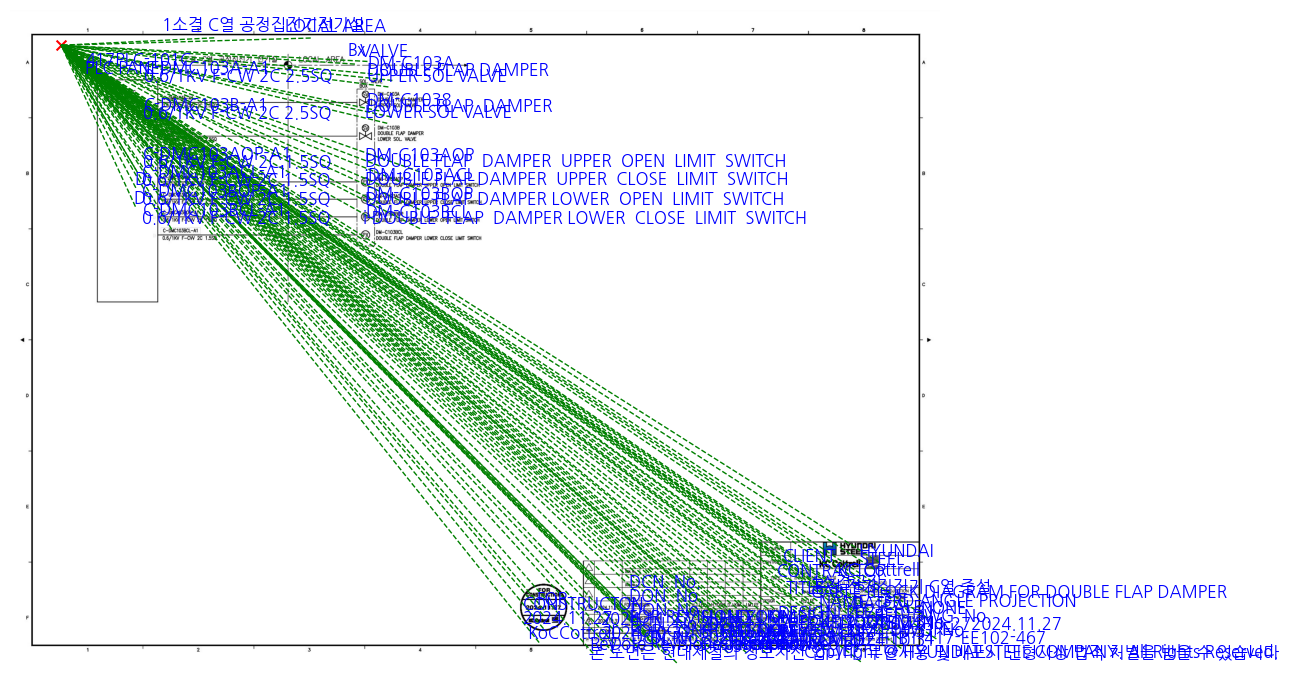

In [22]:
# -------------------------------
# 7. 시각화
# -------------------------------
plt.figure(figsize=(12, 12))
plt.imshow(image_rgb)

# 도형 중심 표시
for cx, cy in shape_centers:
    plt.scatter(cx, cy, c='red', s=50, marker='x')

# 텍스트 표시
for item in mapped:
    x1, y1, x2, y2 = item['bbox']
    text = item['text']
    shape_center = item['shape']
    plt.text(x1, y1-5, text, color='blue', fontsize=12, fontproperties=font_prop)
    if shape_center:
        plt.plot([item['center'][0], shape_center[0]],
                 [item['center'][1], shape_center[1]], 'g--', linewidth=1)

plt.axis('off')
plt.show()

총 1개의 도형 중심 좌표 추출됨:
도형 1: (134, 93)


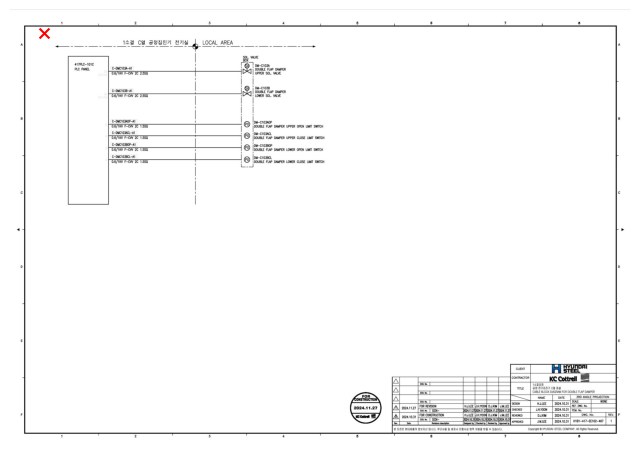

In [23]:
import torch
from PIL import Image
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1. 이미지 로드
# -------------------------------
image_path = "./data/test05.JPG"
image_pil = Image.open(image_path).convert("RGB")
W, H = image_pil.size

# -------------------------------
# 2. SlimSAM 모델 불러오기
# -------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_id = "Zigeng/SlimSAM-uniform-77"

model = SamModel.from_pretrained(model_id).eval().to(device)
processor = SamProcessor.from_pretrained(model_id)

# -------------------------------
# 3. 이미지 입력 전처리
# -------------------------------
box = torch.tensor([[[0, 0, W, H]]], dtype=torch.float).to(device)  # 전체 이미지
inputs = processor(image_pil, boxes=box, return_tensors="pt").to(device)

# -------------------------------
# 4. 모델 추론
# -------------------------------
with torch.no_grad():
    outputs = model(**inputs)

# -------------------------------
# 5. 마스크 추출 및 중심 좌표 계산
# -------------------------------
mask_list = outputs.masks if hasattr(outputs, "masks") else outputs.pred_masks

shape_centers = []
mask_arrays = []

for mask in mask_list:
    mask_np = mask.cpu().numpy() if torch.is_tensor(mask) else mask
    # batch=0, channel=0 선택
    mask_np = mask_np[0, 0] if mask_np.ndim == 4 else mask_np
    mask_bin = mask_np > 0.5
    ys, xs = np.where(mask_bin)
    if len(xs) == 0:
        continue
    cx, cy = int(xs.mean()), int(ys.mean())
    shape_centers.append((cx, cy))
    mask_arrays.append(mask_bin)

print(f"총 {len(shape_centers)}개의 도형 중심 좌표 추출됨:")
for i, (cx, cy) in enumerate(shape_centers):
    print(f"도형 {i+1}: ({cx}, {cy})")

# -------------------------------
# 6. 시각화
# -------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(image_pil)

# 마스크 중심 표시
for cx, cy in shape_centers:
    plt.scatter(cx, cy, c='red', s=50, marker='x')

plt.axis('off')
plt.show()
